<a href="https://colab.research.google.com/github/amirparizi/FaceClassificationWithInception/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required packages & directories

In [27]:
import os
import random
from shutil import copyfile
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Test_dir ='/content/drive/My Drive/Fake Faces/First600/'

In [4]:
len(os.listdir(Test_dir))

1000

In [5]:
TRAINING_DIR = "/content/drive/My Drive/Fake Faces/Training/"
TESTING_DIR = "/content/drive/My Drive/Fake Faces/Testing/"

In [6]:
print(len(os.listdir(TRAINING_DIR)))
print(len(os.listdir(TESTING_DIR)))

899
101


# Import Dataset & preliminary figures

In [7]:
traindf=pd.read_csv('/content/drive/My Drive/Fake Faces/faces_dataset.csv',dtype=str)

In [8]:
def append_ext(fn):
    return "image_"+fn+'.jpg'

traindf["ID"]=traindf["ID"].apply(append_ext)


In [9]:
traindf

,ID,SEX,EXPRESSIONS,AGE,Unnamed: 4,Unnamed: 5
0,image_1.jpg,Female,Happy,Adult,NaN,NaN
1,image_2.jpg,Female,Happy,Adult,NaN,NaN
2,image_3.jpg,Male,Neutral,Kid,NaN,NaN
3,image_4.jpg,Male,Neutral,Kid,NaN,NaN
4,image_5.jpg,Male,Neutral,Adult,NaN,NaN
...,...,...,...,...,...,...
995,image_996.jpg,Female,Happy,Adult,NaN,NaN
996,image_997.jpg,Female,Neutral,Adult,NaN,NaN
997,image_998.jpg,Female,Neutral,Adult,NaN,NaN
998,image_999.jpg,Male,Neutral,Adult,NaN,NaN


Text(0, 0.5, 'Number of people in each Category')

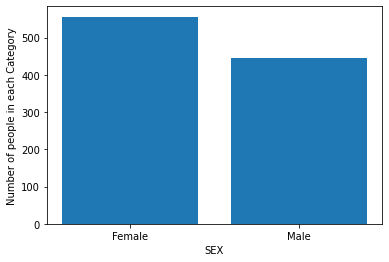

In [10]:
fig,ax=plt.subplots()
SEX=traindf['SEX'].value_counts()
ax.bar(SEX.index,SEX)
plt.xlabel('SEX')
plt.ylabel('Number of people in each Category')

Text(0, 0.5, 'Number of people in each Category')

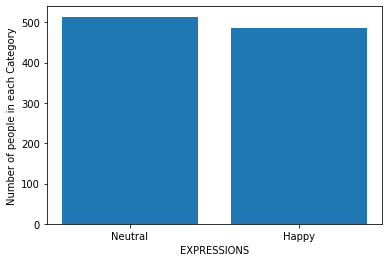

In [11]:
fig,ax=plt.subplots()
SEX=traindf['EXPRESSIONS'].value_counts()
ax.bar(SEX.index,SEX)
plt.xlabel('EXPRESSIONS')
plt.ylabel('Number of people in each Category')

# Import Training and Testing sets using DataGenerator

In [12]:
test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=traindf,
directory=TESTING_DIR,
x_col="ID",
y_col="SEX",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 899 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=TRAINING_DIR,
x_col="ID",
y_col="SEX",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

Found 899 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 101 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [14]:
train_datagen_2 = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator_2=train_datagen_2.flow_from_dataframe(
dataframe=traindf,
directory=TRAINING_DIR,
x_col="ID",
y_col="EXPRESSIONS",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

test_datagen_2 = ImageDataGenerator(rescale = 1./255.)
test_generator_2=test_datagen_2.flow_from_dataframe(
dataframe=traindf,
directory=TESTING_DIR,
x_col="ID",
y_col="EXPRESSIONS",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

Found 899 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 101 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 899 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Simple CNN

In [15]:
model_SimpleCNN_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_SimpleCNN_1.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [16]:
history_SimpleCNN_1 = model_SimpleCNN_1.fit_generator(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=test_generator,
                              steps_per_epoch = 10)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 [==============================] - 13s 1s/step - loss: 1.9279 - acc: 0.4949 - val_loss: 0.6596 - val_acc: 0.5941
Epoch 2/10
10/10 [==============================] - 13s 1s/step - loss: 0.7088 - acc: 0.5455 - val_loss: 0.6703 - val_acc: 0.5149
Epoch 3/10
10/10 [==============================] - 12s 1s/step - loss: 0.6860 - acc: 0.4900 - val_loss: 0.6529 - val_acc: 0.6733
Epoch 4/10
10/10 [==============================] - 12s 1s/step - loss: 0.6962 - acc: 0.5051 - val_loss: 0.6617 - val_acc: 0.6337
Epoch 5/10
10/10 [==============================] - 12s 1s/step - loss: 0.7082 - acc: 0.5000 - val_loss: 0.6741 - val_acc: 0.6832
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 0.7159 - acc: 0.6600 - val_loss: 0.6741 - val_acc: 0.5545
Epoch 7/10
10/10 [==============================] - 13s 1s/step - loss: 0.6423 - acc: 0.6200 - val_loss: 0.6281 - val_acc: 0.6733
Epoch 8/10
10/

Text(0.5, 1.0, 'Training and validation loss')

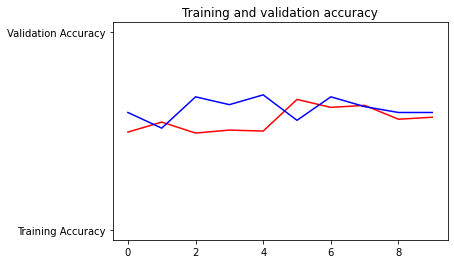

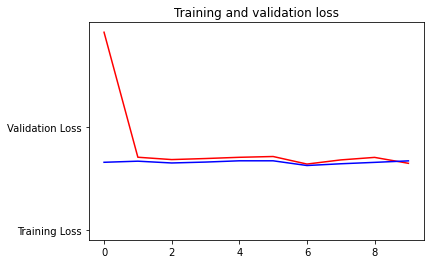

In [17]:
acc=history_SimpleCNN_1.history['acc']
val_acc=history_SimpleCNN_1.history['val_acc']
loss=history_SimpleCNN_1.history['loss']
val_loss=history_SimpleCNN_1.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [18]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
prediction=[]
actual=[]
for i in os.listdir(TESTING_DIR):
  if ((traindf['SEX'][(int(i[6:-4]))-1]) == 'Female'):
    actual.append(0)
  else:
    actual.append(1)
  path = '/content/drive/My Drive/Fake Faces/Testing/' +i
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x=x/255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  pre =model_SimpleCNN_1.predict(images, batch_size=10)
  if (pre[0]) < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
conf_mat = confusion_matrix(actual, prediction) 
conf_mat


array([[43, 11],
       [30, 17]])

In [19]:
train_datagen_2 = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator_2=train_datagen_2.flow_from_dataframe(
dataframe=traindf,
directory=TRAINING_DIR,
x_col="ID",
y_col="EXPRESSIONS",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

test_datagen_2 = ImageDataGenerator(rescale = 1./255.)
test_generator_2=test_datagen_2.flow_from_dataframe(
dataframe=traindf,
directory=TESTING_DIR,
x_col="ID",
y_col="EXPRESSIONS",
batch_size=10,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(150,150))

Found 899 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 101 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 899 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [20]:
model_SimpleCNN_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_SimpleCNN_2.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
history_2 = model_SimpleCNN_2.fit_generator(train_generator_2,
            validation_data = test_generator_2,
            steps_per_epoch = 10,
            epochs = 10,
            verbose = 1,
            )

Epoch 1/10
10/10 [==============================] - 40s 4s/step - loss: 11.3490 - acc: 0.4800 - val_loss: 0.7679 - val_acc: 0.3861
Epoch 2/10
10/10 [==============================] - 39s 4s/step - loss: 0.7221 - acc: 0.4700 - val_loss: 0.6832 - val_acc: 0.6139
Epoch 3/10
10/10 [==============================] - 38s 4s/step - loss: 0.7358 - acc: 0.4000 - val_loss: 0.6837 - val_acc: 0.6139
Epoch 4/10
10/10 [==============================] - 38s 4s/step - loss: 0.6917 - acc: 0.5400 - val_loss: 0.7396 - val_acc: 0.3861
Epoch 5/10
10/10 [==============================] - 38s 4s/step - loss: 0.7101 - acc: 0.4300 - val_loss: 0.7025 - val_acc: 0.4158
Epoch 6/10
10/10 [==============================] - 39s 4s/step - loss: 0.7020 - acc: 0.4600 - val_loss: 0.6907 - val_acc: 0.5248
Epoch 7/10
10/10 [==============================] - 39s 4s/step - loss: 1.0700 - acc: 0.5600 - val_loss: 0.9257 - val_acc: 0.3861
Epoch 8/10
10/10 [==============================] - 38s 4s/step - loss: 0.7414 - acc: 0.5

Text(0.5, 1.0, 'Training and validation loss')

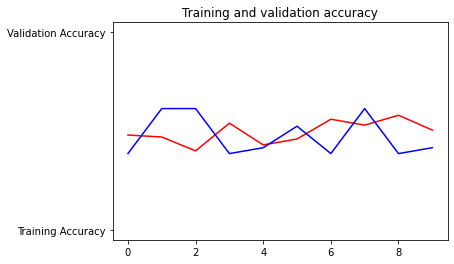

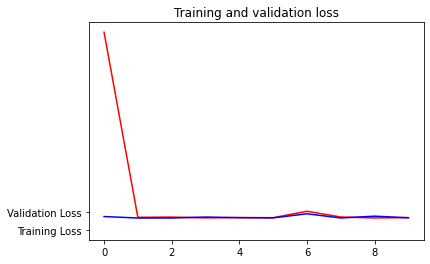

In [22]:
acc=history_2.history['acc']
val_acc=history_2.history['val_acc']
loss=history_2.history['loss']
val_loss=history_2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [25]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
prediction=[]
actual=[]
for i in os.listdir(TESTING_DIR):
  if ((traindf['EXPRESSIONS'][(int(i[6:-4]))-1]) == 'Happy'):
    actual.append(0)
  else:
    actual.append(1)
  path = '/content/drive/My Drive/Fake Faces/Testing/' +i
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x=x/255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  pre =model_SimpleCNN_2.predict(images, batch_size=10)
  if (pre[0]) < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
conf_mat = confusion_matrix(actual, prediction) 
conf_mat

array([[38,  1],
       [58,  4]])

# VGG16

In [28]:
resnet_weights = '/content/drive/My Drive/Fake Faces/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
model_VGG16_1 = Sequential()

model_VGG16_1.add(VGG16(weights=resnet_weights,input_shape = (150, 150, 3), 
                                include_top = False)),
model_VGG16_1.add(Flatten())
model_VGG16_1.add(BatchNormalization())
model_VGG16_1.add(Dense(2048, activation='relu'))
model_VGG16_1.add(BatchNormalization())
model_VGG16_1.add(Dense(1024, activation='relu'))
model_VGG16_1.add(BatchNormalization())
model_VGG16_1.add(Dense(1, activation='sigmoid'))

model_VGG16_1.layers[0].trainable = False


In [29]:
model_VGG16_1.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
history_VGG16_1= model_VGG16_1.fit_generator(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=test_generator,
                              steps_per_epoch = 10)

Epoch 1/10
10/10 [==============================] - 53s 5s/step - loss: 0.9934 - accuracy: 0.5500 - val_loss: 0.6714 - val_accuracy: 0.5743
Epoch 2/10
10/10 [==============================] - 52s 5s/step - loss: 1.0180 - accuracy: 0.5900 - val_loss: 0.6179 - val_accuracy: 0.6931
Epoch 3/10
10/10 [==============================] - 52s 5s/step - loss: 0.6704 - accuracy: 0.7200 - val_loss: 0.5932 - val_accuracy: 0.6931
Epoch 4/10
10/10 [==============================] - 51s 5s/step - loss: 0.4782 - accuracy: 0.8485 - val_loss: 0.5471 - val_accuracy: 0.7624
Epoch 5/10
10/10 [==============================] - 52s 5s/step - loss: 0.7094 - accuracy: 0.7071 - val_loss: 0.6389 - val_accuracy: 0.6337
Epoch 6/10
10/10 [==============================] - 52s 5s/step - loss: 0.7193 - accuracy: 0.7200 - val_loss: 0.6329 - val_accuracy: 0.6832
Epoch 7/10
10/10 [==============================] - 52s 5s/step - loss: 0.6242 - accuracy: 0.7400 - val_loss: 0.5341 - val_accuracy: 0.7426
Epoch 8/10
10/10 [==

Text(0.5, 1.0, 'Training and validation loss')

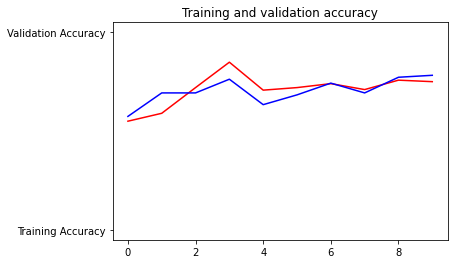

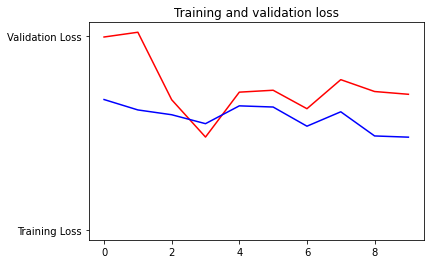

In [31]:
acc=history_VGG16_1.history['accuracy']
val_acc=history_VGG16_1.history['val_accuracy']
loss=history_VGG16_1.history['loss']
val_loss=history_VGG16_1.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [33]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
prediction=[]
actual=[]
for i in os.listdir(TESTING_DIR):
  if ((traindf['SEX'][(int(i[6:-4]))-1]) == 'Female'):
    actual.append(0)
  else:
    actual.append(1)
  path = '/content/drive/My Drive/Fake Faces/Testing/' +i
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x=x/255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  pre = model_VGG16_1.predict(images, batch_size=10)
  if (pre[0]) < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
conf_mat = confusion_matrix(actual, prediction) 
conf_mat


array([[41, 13],
       [ 9, 38]])

In [34]:
model_VGG16_2 = Sequential()

model_VGG16_2.add(VGG16(weights=resnet_weights,input_shape = (150, 150, 3), 
                                include_top = False)),
model_VGG16_2.add(Flatten())
model_VGG16_2.add(BatchNormalization())
model_VGG16_2.add(Dense(2048, activation='relu'))
model_VGG16_2.add(BatchNormalization())
model_VGG16_2.add(Dense(1024, activation='relu'))
model_VGG16_2.add(BatchNormalization())
model_VGG16_2.add(Dense(1, activation='sigmoid'))

model_VGG16_2.layers[0].trainable = False
model_VGG16_2.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
history_VGG16_2= model_VGG16_2.fit_generator(train_generator_2,
                              epochs=10,
                              verbose=1,
                              validation_data=test_generator_2,
                              steps_per_epoch = 10)

Epoch 1/10
10/10 [==============================] - 53s 5s/step - loss: 1.0651 - accuracy: 0.5300 - val_loss: 0.6231 - val_accuracy: 0.6238
Epoch 2/10
10/10 [==============================] - 51s 5s/step - loss: 0.9642 - accuracy: 0.5300 - val_loss: 0.6371 - val_accuracy: 0.6238
Epoch 3/10
10/10 [==============================] - 52s 5s/step - loss: 0.9564 - accuracy: 0.6200 - val_loss: 0.6106 - val_accuracy: 0.6535
Epoch 4/10
10/10 [==============================] - 52s 5s/step - loss: 0.9392 - accuracy: 0.6000 - val_loss: 0.6199 - val_accuracy: 0.6337
Epoch 5/10
10/10 [==============================] - 52s 5s/step - loss: 0.9167 - accuracy: 0.5900 - val_loss: 0.5794 - val_accuracy: 0.6832
Epoch 6/10
10/10 [==============================] - 52s 5s/step - loss: 0.7535 - accuracy: 0.6500 - val_loss: 0.5585 - val_accuracy: 0.6733
Epoch 7/10
10/10 [==============================] - 55s 5s/step - loss: 0.7443 - accuracy: 0.6300 - val_loss: 0.5619 - val_accuracy: 0.7327
Epoch 8/10
10/10 [==

Text(0.5, 1.0, 'Training and validation loss')

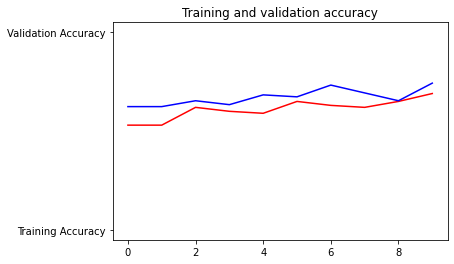

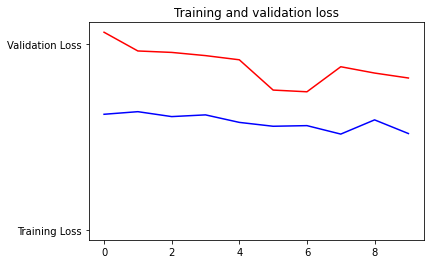

In [35]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_VGG16_2.history['accuracy']
val_acc=history_VGG16_2.history['val_accuracy']
loss=history_VGG16_2.history['loss']
val_loss=history_VGG16_2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [36]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
prediction=[]
actual=[]
for i in os.listdir(TESTING_DIR):
  if ((traindf['EXPRESSIONS'][(int(i[6:-4]))-1]) == 'Happy'):
    actual.append(0)
  else:
    actual.append(1)
  path = '/content/drive/My Drive/Fake Faces/Testing/' +i
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x=x/255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  pre = model_VGG16_2.predict(images, batch_size=10)
  if (pre[0]) < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
conf_mat = confusion_matrix(actual, prediction) 
conf_mat


array([[20, 19],
       [ 7, 55]])

# Transfer Learning using InceptionV3 model

In [37]:
local_weights_file = '/content/drive/My Drive/Fake Faces/inception_v3_weights.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [38]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           
model_Inception_1 = Model( pre_trained_model.input, x) 
model_Inception_1.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [39]:
history = model_Inception_1.fit_generator(train_generator,
            validation_data = test_generator,
            steps_per_epoch = 10,
            epochs = 10,
            verbose = 1,
            )


Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 1.3263 - accuracy: 0.5000 - val_loss: 0.4964 - val_accuracy: 0.7822
Epoch 2/10
10/10 [==============================] - 17s 2s/step - loss: 0.6128 - accuracy: 0.7200 - val_loss: 0.4449 - val_accuracy: 0.8119
Epoch 3/10
10/10 [==============================] - 17s 2s/step - loss: 0.5164 - accuracy: 0.7200 - val_loss: 0.6046 - val_accuracy: 0.7129
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 0.4749 - accuracy: 0.7800 - val_loss: 0.4009 - val_accuracy: 0.8317
Epoch 5/10
10/10 [==============================] - 18s 2s/step - loss: 0.4776 - accuracy: 0.7900 - val_loss: 0.3447 - val_accuracy: 0.8515
Epoch 6/10
10/10 [==============================] - 18s 2s/step - loss: 0.6289 - accuracy: 0.7500 - val_loss: 0.6578 - val_accuracy: 0.6832
Epoch 7/10
10/10 [==============================] - 18s 2s/step - loss: 0.3691 - accuracy: 0.8700 - val_loss: 0.3874 - val_accuracy: 0.8416
Epoch 8/10
10/10 [==

Text(0.5, 1.0, 'Training and validation loss')

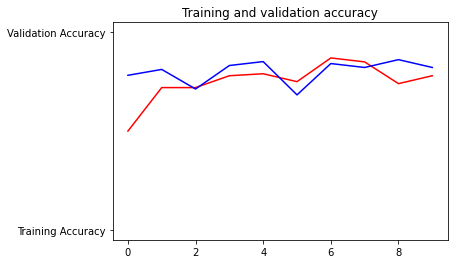

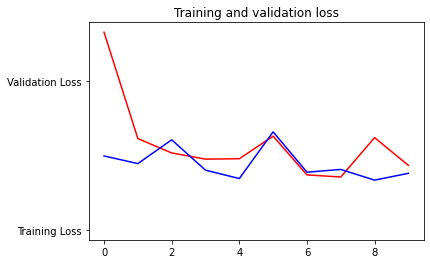

In [40]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [41]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
prediction=[]
actual=[]
for i in os.listdir(TESTING_DIR):
  if ((traindf['SEX'][(int(i[6:-4]))-1]) == 'Female'):
    actual.append(0)
  else:
    actual.append(1)
  path = '/content/drive/My Drive/Fake Faces/Testing/' +i
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x=x/255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  pre = model_Inception_1.predict(images, batch_size=10)
  if (pre[0]) < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)



In [43]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(actual, prediction) 
conf_mat

array([[36, 18],
       [ 0, 47]])

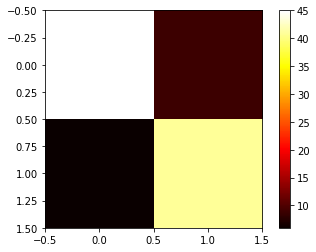

In [ ]:
plt.imshow(conf_mat, cmap='hot')
plt.colorbar()
plt.show()

In [45]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           
model_Inception_2 = Model( pre_trained_model.input, x) 
model_Inception_2.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [46]:

history_2 = model_Inception_2.fit_generator(train_generator_2,
            validation_data = test_generator_2,
            steps_per_epoch = 10,
            epochs = 10,
            verbose = 1,
            )


Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 1.2604 - accuracy: 0.5100 - val_loss: 0.5859 - val_accuracy: 0.6436
Epoch 2/10
10/10 [==============================] - 18s 2s/step - loss: 0.7879 - accuracy: 0.5900 - val_loss: 0.5781 - val_accuracy: 0.7030
Epoch 3/10
10/10 [==============================] - 18s 2s/step - loss: 0.6686 - accuracy: 0.6500 - val_loss: 1.1427 - val_accuracy: 0.4257
Epoch 4/10
10/10 [==============================] - 21s 2s/step - loss: 0.8120 - accuracy: 0.5859 - val_loss: 0.8026 - val_accuracy: 0.6238
Epoch 5/10
10/10 [==============================] - 18s 2s/step - loss: 0.9709 - accuracy: 0.4900 - val_loss: 0.5585 - val_accuracy: 0.6832
Epoch 6/10
10/10 [==============================] - 18s 2s/step - loss: 0.5807 - accuracy: 0.7000 - val_loss: 0.6174 - val_accuracy: 0.6832
Epoch 7/10
10/10 [==============================] - 18s 2s/step - loss: 0.6867 - accuracy: 0.6465 - val_loss: 0.8321 - val_accuracy: 0.5644
Epoch 8/10
10/10 [==

Text(0.5, 1.0, 'Training and validation loss')

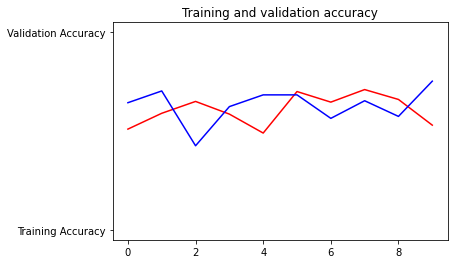

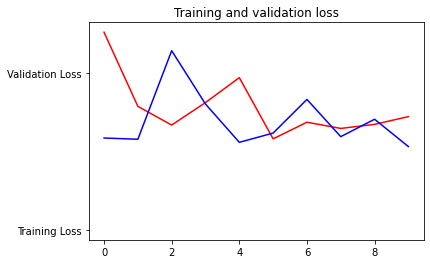

In [47]:
acc=history_2.history['accuracy']
val_acc=history_2.history['val_accuracy']
loss=history_2.history['loss']
val_loss=history_2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [48]:
prediction=[]
actual=[]
for i in os.listdir(TESTING_DIR):
  if ((traindf['EXPRESSIONS'][(int(i[6:-4]))-1]) == 'Happy'):
    actual.append(0)
  else:
    actual.append(1)
  path = '/content/drive/My Drive/Fake Faces/Testing/' +i
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x=x/255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  pre = model_Inception_2.predict(images, batch_size=10)
  if (pre[0]) < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)


In [49]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(actual, prediction) 
conf_mat

array([[32,  7],
       [18, 44]])

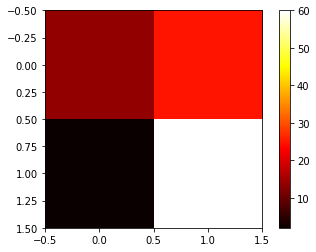

In [ ]:
plt.imshow(conf_mat, cmap='hot')
plt.colorbar()
plt.show()

# Upload photo or use Webcam to test models

Saving test2.jpg to test2.jpg


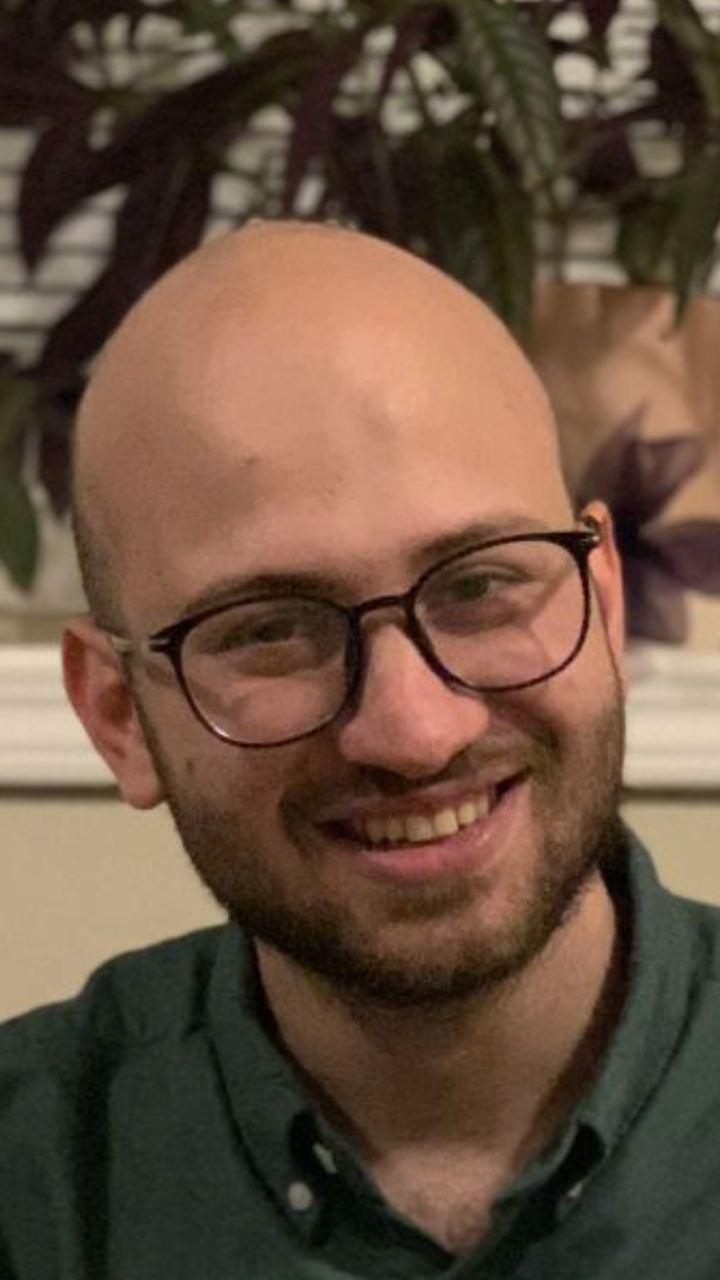

This is a Male
This person looks like Happy


In [57]:

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x=x/255
  x = np.expand_dims(x, axis=0)
  display(Image(path))
  images = np.vstack([x])
  classes = model_Inception_1.predict(images, batch_size=10)
  if (classes[0]) < 0.5:
    print('This is a Female')
  else:
    print('This is a Male')
  classes_2 = model_Inception_2.predict(images, batch_size=10)
  if (classes_2[0]) < 0.5:
    print('This person looks like Happy')
  else:
    print('This person looks like Neutral')


In [50]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


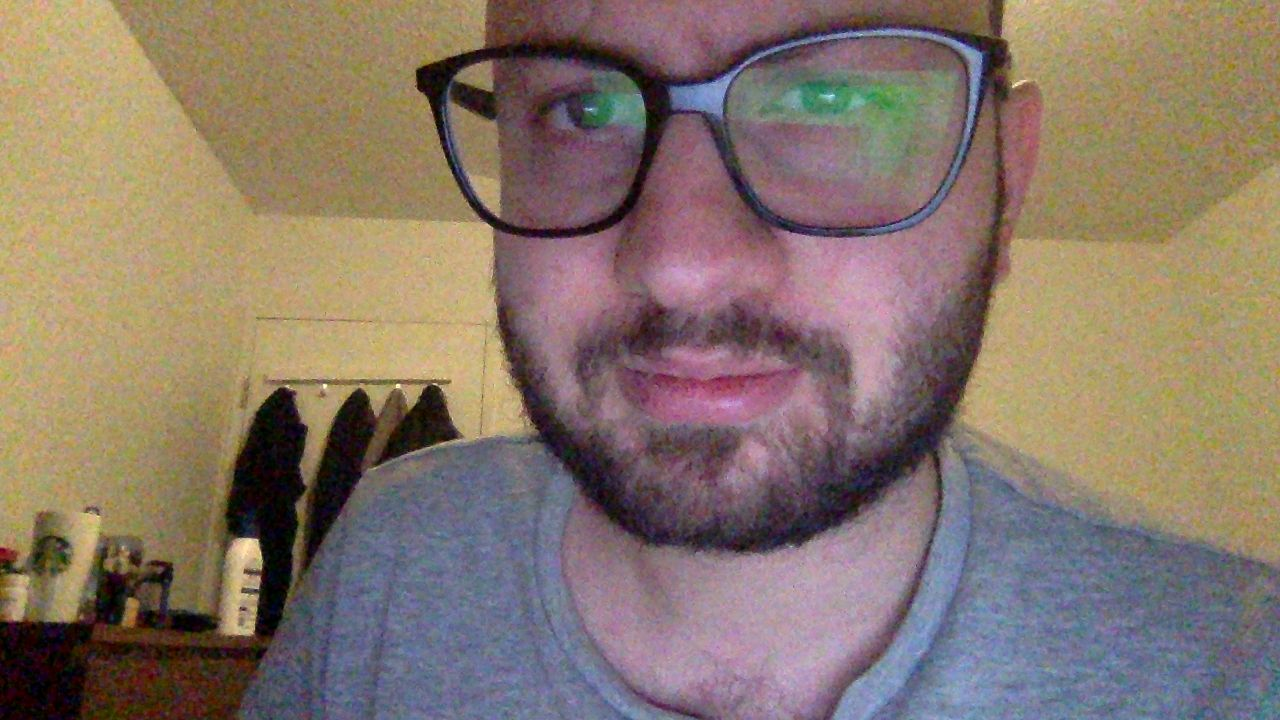

This is a Male
This person looks like Neutral


In [60]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
path = '/content/photo.jpg'
img = image.load_img(path, target_size=(150,150))
x = image.img_to_array(img)
x=x/255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model_Inception_1.predict(images, batch_size=10)
if (classes[0]) < 0.5:
    print('This is a Female')
else:
    print('This is a Male')
classes_2 = model_Inception_2.predict(images, batch_size=10)
if (classes_2[0]) < 0.5:
    print('This person looks like Happy')
else:
    print('This person looks like Neutral')

# Conclusion

In this project two different data sets were combined and used ( www.thispersondoesnotexist.com & https://www.face-rec.org/databases/). 1000 pictures were labeled and fed into three different NN architecture. 
1. simple CNN with 3 Conv layers
2. VGG16 with loaded weights
3. InceptionV3 

Here you can find the summary of the results from these three models. Also you can try your own pictures or capture pictures using your webcam (InceptionV3 used as a model)




In [64]:
table=pd.read_csv('/content/drive/My Drive/Fake Faces/table_fakefaces.csv',)
table

,Model,Feature,TP,FP,FN,TN,Precision,Recall,F1-Score,Accuracy
0,Simple CNN,Gender,43,11,30,17,0.796296,0.589041,0.677165,0.594059
1,VGG16,Gender,41,13,9,38,0.759259,0.820000,0.788462,0.782178
2,InceptionV3,Gender,36,18,0,47,0.666667,1.000000,0.800000,0.821782
3,Simple CNN,Expression,38,1,58,4,0.974359,0.395833,0.562963,0.415842
4,VGG16,Expression,20,19,7,55,0.512821,0.740741,0.606061,0.742574
5,InceptionV3,Expression,32,7,18,44,0.820513,0.640000,0.719101,0.752475


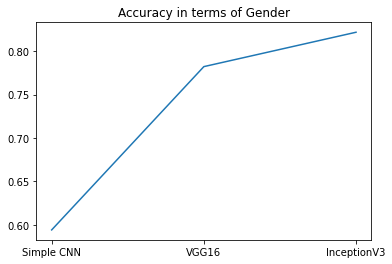

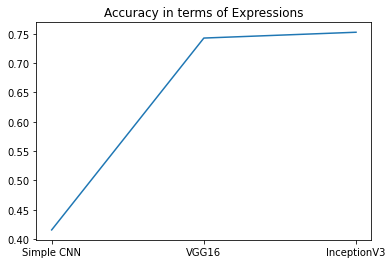

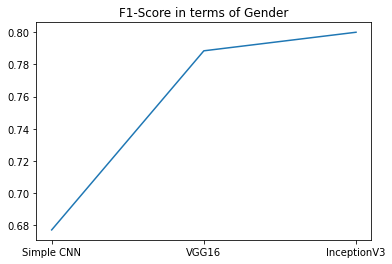

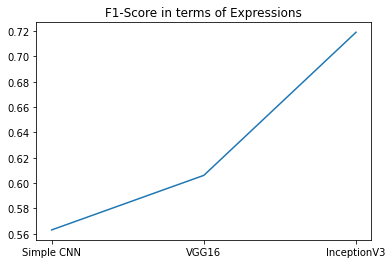

<Figure size 432x288 with 0 Axes>

In [89]:
plt.plot(table['Model '][0:3],table['Accuracy'][0:3]);
plt.title('Accuracy in terms of Gender');
plt.figure();
plt.plot(table['Model '][3:6],table['Accuracy'][3:6]);
plt.title('Accuracy in terms of Expressions');
plt.figure();
plt.plot(table['Model '][0:3],table['F1-Score'][0:3]);
plt.title('F1-Score in terms of Gender');
plt.figure();
plt.plot(table['Model '][3:6],table['F1-Score'][3:6]);
plt.title('F1-Score in terms of Expressions');
plt.figure();

We can see that F1-score and accuracy both increase as we move from simple CSS to more sophisticated models like VGG16 and ultimately InceptionV3 model. 